# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import re
import nltk
from sklearn.pipeline import Pipeline, FeatureUnion
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report
import pickle
import matplotlib.pyplot as plt

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/sajith/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/sajith/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/sajith/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# load data from database
engine = create_engine('sqlite:///InsertDatabaseName.db')
df = pd.read_sql("select * from InsertTableName", engine)

In [4]:
df['genre'].value_counts()

news      13054
direct    10766
social     2396
Name: genre, dtype: int64

In [5]:
df.isna().any()

id                         True
message                   False
original                   True
genre                     False
related                    True
request                   False
offer                     False
aid_related               False
medical_help              False
medical_products          False
search_and_rescue         False
security                  False
military                  False
child_alone               False
water                     False
food                      False
shelter                   False
clothing                  False
money                     False
missing_people            False
refugees                  False
death                     False
other_aid                 False
infrastructure_related    False
transport                 False
buildings                 False
electricity               False
tools                     False
hospitals                 False
shops                     False
aid_centers               False
other_in

In [6]:
df = df.dropna(subset=['related'], axis=0)

In [7]:
df.isna().any()

id                         True
message                   False
original                   True
genre                     False
related                   False
request                   False
offer                     False
aid_related               False
medical_help              False
medical_products          False
search_and_rescue         False
security                  False
military                  False
child_alone               False
water                     False
food                      False
shelter                   False
clothing                  False
money                     False
missing_people            False
refugees                  False
death                     False
other_aid                 False
infrastructure_related    False
transport                 False
buildings                 False
electricity               False
tools                     False
hospitals                 False
shops                     False
aid_centers               False
other_in

In [8]:
# X = df.iloc[:,2]
# Y = df.iloc[:,4:]

In [9]:
X = df.loc[:, 'message']
Y = df.iloc[:, 4:]

In [10]:
X.values

array(['Weather update - a cold front from Cuba that could pass over Haiti',
       'Is the Hurricane over or is it not over',
       'Looking for someone but no name', ...,
       "Proshika, operating in Cox's Bazar municipality and 5 other unions, Ramu and Chokoria, assessment, 5 kg rice, 1,5 kg lentils to 700 families.",
       'Some 2,000 women protesting against the conduct of the elections were teargassed as they tried to converge on the local electoral commission offices in the southern oil city of Port Harcourt.',
       'A radical shift in thinking came about as a result of this meeting, recognizing that HIV/AIDS is at the core of the humanitarian crisis and identifying the crisis itself as a function of the HIV/AIDS pandemic.'],
      dtype=object)

In [11]:
for text in X.values:.str.split().apply(len).value_counts()
    print(text)

SyntaxError: invalid syntax (<ipython-input-11-5872fdce02a3>, line 1)

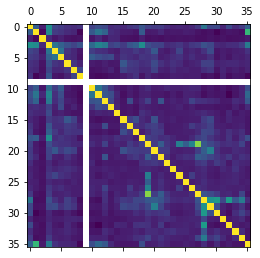

In [12]:
plt.matshow(Y.corr())

In [13]:
Y['request'] = Y['request'].astype('int')

### 2. Write a tokenization function to process your text data

In [20]:
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
url_regex = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'


In [21]:
# starting verbs extractor
class StartingVerbExtractor(BaseEstimator, TransformerMixin):

    @staticmethod
    def starting_verb(text):
        sentence_list = nltk.sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize_text(sentence))
            if len(pos_tags) != 0:
                first_word, first_tag = pos_tags[0]
                if first_tag in ['VB', 'VBP']:
                    return True
        return False

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.starting_verb)
        return pd.DataFrame(X_tagged)


class VerbCountExtractor(BaseEstimator, TransformerMixin):

    @staticmethod
    def count_verbs(text):
        total_verbs = 0
        pos_tags = nltk.pos_tag(tokenize_text(text))
        for word, tag in pos_tags:
            if tag in ['VB', 'VBP', 'VBD']:
                total_verbs = total_verbs + 1

        return total_verbs

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.count_verbs)
        return pd.DataFrame(X_tagged)


class NounCountExtractor(BaseEstimator, TransformerMixin):
    @staticmethod
    def count_nouns(text):
        total_nouns = 0
        pos_tags = nltk.pos_tag(tokenize_text(text))
        for word, tag in pos_tags:
            if tag in ['NN', 'NNS', 'NNPS', 'NNP']:
                total_nouns = total_nouns + 1

        return total_nouns

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.count_nouns)
        return pd.DataFrame(X_tagged)


class StartingModalExtractor(BaseEstimator, TransformerMixin):
    @staticmethod
    def starting_modals(text):
        sentence_list = nltk.sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize_text(sentence))
            if len(pos_tags) != 0:
                first_word, first_tag = pos_tags[0]
                if first_tag == 'MD':
                    return True
        return False

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.starting_modals)
        return pd.DataFrame(X_tagged)


In [22]:
def tokenize_text(text):
    """
        Apply case normalization, lemmatize and tokenize text.

        INPUT:
            text -- text in source format
        OUTPUT:
            clean_tokens -- cleaned tokenized list
    """

    # transform to lower case
    text = text.lower()
    # remove urls
    text = re.sub(url_regex, " ", text)
    # remove punctuations
    text = re.sub(r"[^A-Za-z0-9]+", " ", text)
    # remove numbers
    text = re.sub(r"\d+", " ", text)
    # tokenize for words
    words = word_tokenize(text)
    # Remove stop words
    tokens = [w for w in words if w not in stopwords.words("english")]
    # lemmatize the tokens
    clean_tokens = list(map(lambda token: lemmatizer.lemmatize(token).strip(), tokens))
    return clean_tokens


### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [23]:
def build_pipeline(estimator):
    """
    This separate function can be used to test with multiple estimators.
    INPUT:
        estimator - An estimator that is used to build `sklearn.pipeline` Pipeline

    OUTPUT:
        pipeline - `sklearn.pipeline` with a estimator and multiple features.
    """

    # define pipeline
    pipeline = Pipeline([
        ('features', FeatureUnion([
            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize_text)),
                ('tfidf', TfidfTransformer())
            ])),
            ('starting_verb_noun', StartingVerbExtractor()),
            ('count_verbs', VerbCountExtractor()),
            ('count_nouns', NounCountExtractor()),
            ('starting_modals', StartingModalExtractor())
        ])),

        ('clf', estimator)
    ])

    return pipeline

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size = 0.2, random_state = 0)

In [25]:
multi_label_estimators = []
multi_label_estimator1 = MultiOutputClassifier(OneVsRestClassifier(SGDClassifier(loss='modified_huber', penalty='elasticnet',
                                          alpha=1e-4,  random_state=42,
                                          shuffle=True, n_jobs=5)))
multi_label_estimators.append(multi_label_estimator1)

multi_label_estimator2 = MultiOutputClassifier(OneVsRestClassifier(MultinomialNB()))
multi_label_estimators.append(multi_label_estimator2)

multi_label_estimator3 = MultiOutputClassifier(OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=5))
multi_label_estimators.append(multi_label_estimator3)

multi_label_estimator4 = MultiOutputClassifier(OneVsRestClassifier(RandomForestClassifier(n_jobs = 5)))
multi_label_estimators.append(multi_label_estimator4)

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [ ]:
for i , estimator in enumerate(multi_label_estimators):
    pipeline = build_pipeline(estimator)
    pipeline.fit(X_train, Y_train)
    prediction = pipeline.predict(X_test)
    print(classification_report(Y_test, prediction, target_names=Y.columns.values))

In [26]:
estimator = MultiOutputClassifier(OneVsRestClassifier(RandomForestClassifier(n_jobs = 5)))
pipeline = build_pipeline(estimator)

In [27]:
pipeline.fit(X_train, Y_train)

/home/sajith/Documents/Acedamic/Projects/Python3.6/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))


Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('text_pipeline',
                                                 Pipeline(memory=None,
                                                          steps=[('vect',
                                                                  CountVectorizer(analyzer='word',
                                                                                  binary=False,
                                                                                  decode_error='strict',
                                                                                  dtype=<class 'numpy.int64'>,
                                                                                  encoding='utf-8',
                                                                                  input='content',
                                                                                  low

In [28]:
prediction = pipeline.predict(X_test)

In [29]:
print(classification_report(Y_test, prediction, target_names=Y.columns.values))

                        precision    recall  f1-score   support

               related       0.83      0.96      0.89      3983
               request       0.86      0.51      0.64       931
                 offer       0.00      0.00      0.00        20
           aid_related       0.77      0.70      0.73      2226
          medical_help       0.74      0.06      0.12       447
      medical_products       0.75      0.12      0.20       284
     search_and_rescue       0.62      0.05      0.09       170
              security       0.50      0.01      0.02       104
              military       0.86      0.06      0.12       189
           child_alone       0.00      0.00      0.00         0
                 water       0.91      0.37      0.52       371
                  food       0.84      0.63      0.72       597
               shelter       0.80      0.42      0.55       477
              clothing       0.82      0.12      0.20        77
                 money       0.67      

/home/sajith/Documents/Acedamic/Projects/Python3.6/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sajith/Documents/Acedamic/Projects/Python3.6/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sajith/Documents/Acedamic/Projects/Python3.6/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_pr

In [ ]:
pickle.dump(pipeline, open('classifier.pkl', 'wb'))

In [ ]:
estimator.get_params()

### 6. Improve your model
Use grid search to find better parameters. 

In [ ]:
parameters = {
        'features__text_pipeline__vect__ngram_range': ((1, 1), (1, 2)),
        'features__text_pipeline__vect__max_df': (0.5, 0.75, 1.0),
        'features__text_pipeline__vect__max_features': (None, 10, 100),
        'features__text_pipeline__tfidf__use_idf': (True, False),
        'clf__estimator__estimator__n_estimators': [100, 200, 1000],
        'clf__estimator__estimator__min_samples_split': [2, 3, 4],
        'features__transformer_weights': (
            {'text_pipeline': 1, 'starting_verb': 0.5},
            {'text_pipeline': 0.5, 'starting_verb': 1},
            {'text_pipeline': 0.8, 'starting_verb': 1},
        )
    }
cv = GridSearchCV(pipeline, param_grid = parameters)

In [ ]:
cv.fit(X_train,Y_train)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 9. Export your model as a pickle file

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.